In [1]:
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random
import shutil

Using TensorFlow backend.


Contruct dataset

In [2]:
images = []
for file in sorted(os.listdir("mask(all)") , key = lambda x:int(x.split(".")[0][0:])):
    images.append(file)

In [3]:
images = np.array(images)
images.shape

(80500,)

In [4]:
types = []
count = 1
for x in range(80500):
    types.append(str(count))
    if x == count*500 :
        count+=1

In [5]:
types = np.array(types)
types.shape

(80500,)

In [6]:
df = pd.DataFrame({
    "images" : images,
    "types" : types
})

In [7]:
df.head()

,images,types
0,1.jpg,1
1,2.jpg,1
2,3.jpg,1
3,4.jpg,1
4,5.jpg,1


Visualization of dataset

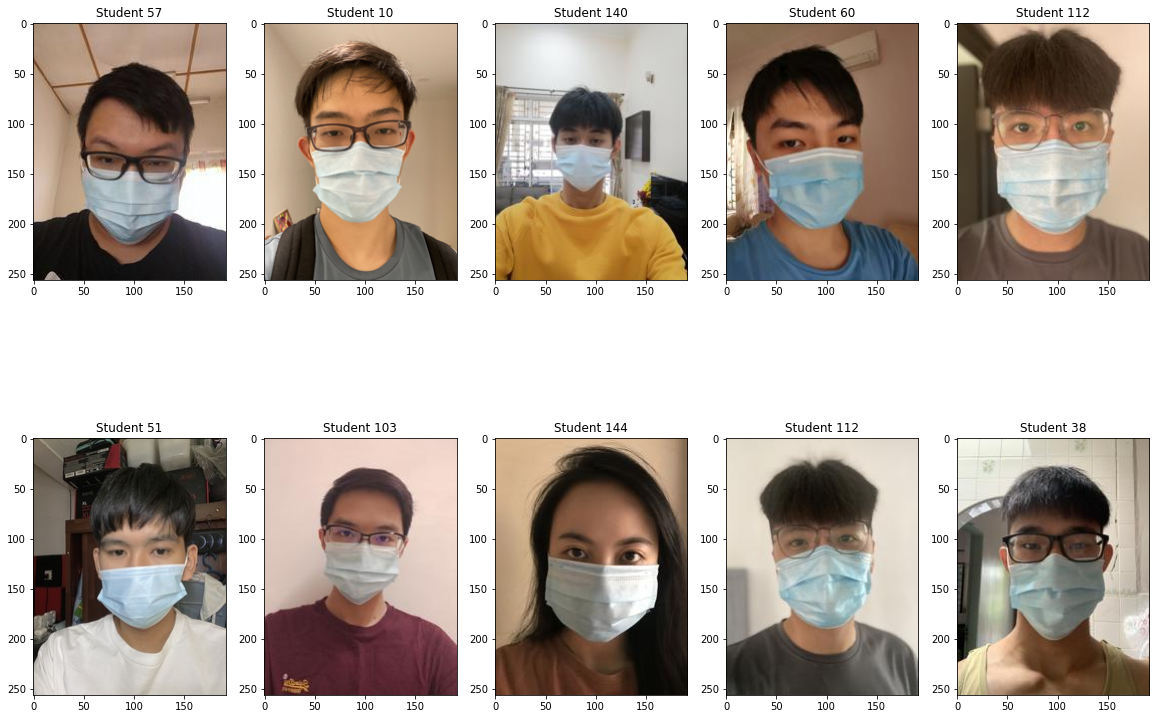

In [8]:
count = 10
images = df.sample(n=10)
plt.figure(figsize=(20,14))
for x in range(count):
    plt.subplot(2,5,x+1)
    img = cv2.imread("mask(all)/"+images.iloc[x][0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title("Student {}".format(images.iloc[x][1]))
    plt.imshow(img)

Split into training/validation/testing set

In [9]:
X_train_df, X_test_df = train_test_split(df,test_size=0.2, random_state=1)
X_train_df = pd.DataFrame(X_train_df)
X_test_df = pd.DataFrame(X_test_df)

In [10]:
print(X_train_df.shape)
print(X_test_df.shape)

(64400, 2)
(16100, 2)


In [11]:
# second time for validation set 
X_train_df, X_val_df = train_test_split(X_train_df, test_size=0.2, random_state=1)
X_train_df = pd.DataFrame(X_train_df)
X_val_df = pd.DataFrame(X_val_df)

In [12]:
print(X_train_df.shape)
print(X_val_df.shape)

(51520, 2)
(12880, 2)


In [13]:
batch_size = 16
epochs = 50

Data Preprocessing (Data Augmentation)

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = X_train_df,
    directory = "mask(all)",
    x_col = 'images',
    y_col = 'types',
    target_size = (128,128),
    class_mode = 'categorical',
    batch_size = batch_size
)
validation_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = X_val_df,
    directory = "mask(all)",
    x_col = 'images',
    y_col = 'types',
    target_size = (128,128),
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 51520 validated image filenames belonging to 161 classes.
Found 12880 validated image filenames belonging to 161 classes.


In [15]:
testing_datagen = ImageDataGenerator(rescale=1./255)
testing_generator = testing_datagen.flow_from_dataframe(
    dataframe = X_test_df,
    directory = "mask(all)",
    x_col = 'images',
    y_col = 'types',
    target_size = (128,128),
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle=False
)

Found 16100 validated image filenames belonging to 161 classes.


Visualize the augmented data

In [16]:
dataaug_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
dataaug_generator = dataaug_datagen.flow_from_dataframe(
    dataframe = X_train_df.sample(n=1),
    directory = "mask(all)",
    x_col = 'images',
    y_col = 'types',
    target_size = (128,128),
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 1 validated image filenames belonging to 1 classes.


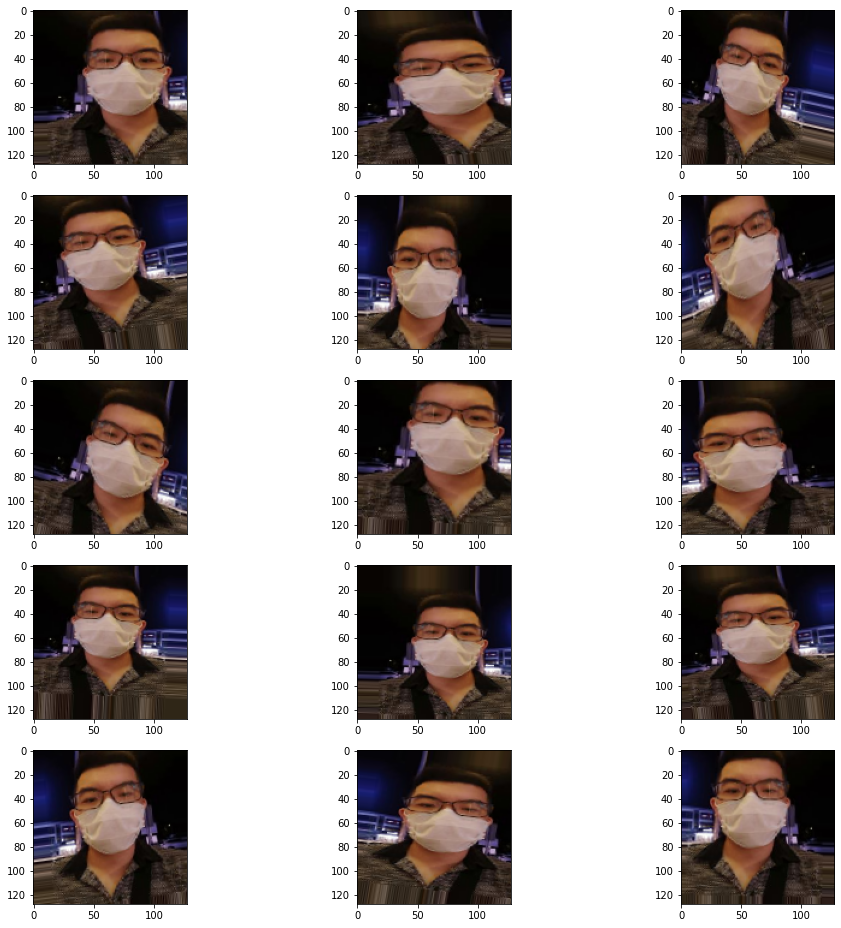

In [17]:
plt.figure(figsize = (15,13))
for x in range(0,15):
    plt.subplot(5,3,x+1)
    for x_batch,y_batch in dataaug_generator:
        plt.imshow(x_batch[0])
        break
plt.tight_layout()
plt.show()

In [18]:
total_validate = X_val_df.shape[0]
total_train = X_train_df.shape[0]

Early stoppping

In [19]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',mode = 'min',patience = 5,verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)

callbacks = [early_stop, learning_rate_reduction]

Construct CNN

In [20]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3),padding='same',activation = 'relu', input_shape =(128,128,3)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64,(3,3),padding='same',activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64,(3,3),padding='same',activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128,(3,3),padding='same',activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(161,activation = 'softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)       

In [20]:
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

In [21]:
history = model.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator, 
    validation_steps = total_validate//batch_size, 
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

Epoch 1/50
3220/3220 [==============================] - 3848s 1s/step - loss: 1.8974 - accuracy: 0.5420 - val_loss: 1.8446 - val_accuracy: 0.6823
Epoch 2/50
3220/3220 [==============================] - 3557s 1s/step - loss: 0.7554 - accuracy: 0.7937 - val_loss: 1.5565 - val_accuracy: 0.8255
Epoch 3/50
3220/3220 [==============================] - 3597s 1s/step - loss: 0.5418 - accuracy: 0.8510 - val_loss: 0.2964 - val_accuracy: 0.8814
Epoch 4/50
3220/3220 [==============================] - 3312s 1s/step - loss: 0.4363 - accuracy: 0.8793 - val_loss: 0.3450 - val_accuracy: 0.9092
Epoch 5/50
3220/3220 [==============================] - 3047s 946ms/step - loss: 0.3728 - accuracy: 0.8959 - val_loss: 0.5281 - val_accuracy: 0.9402
Epoch 6/50
3220/3220 [==============================] - 3191s 991ms/step - loss: 0.3382 - accuracy: 0.9072 - val_loss: 1.0943 - val_accuracy: 0.8082
Epoch 7/50
3220/3220 [==============================] - 3248s 1s/step - loss: 0.2989 - accuracy: 0.9188 - val_loss: 0.

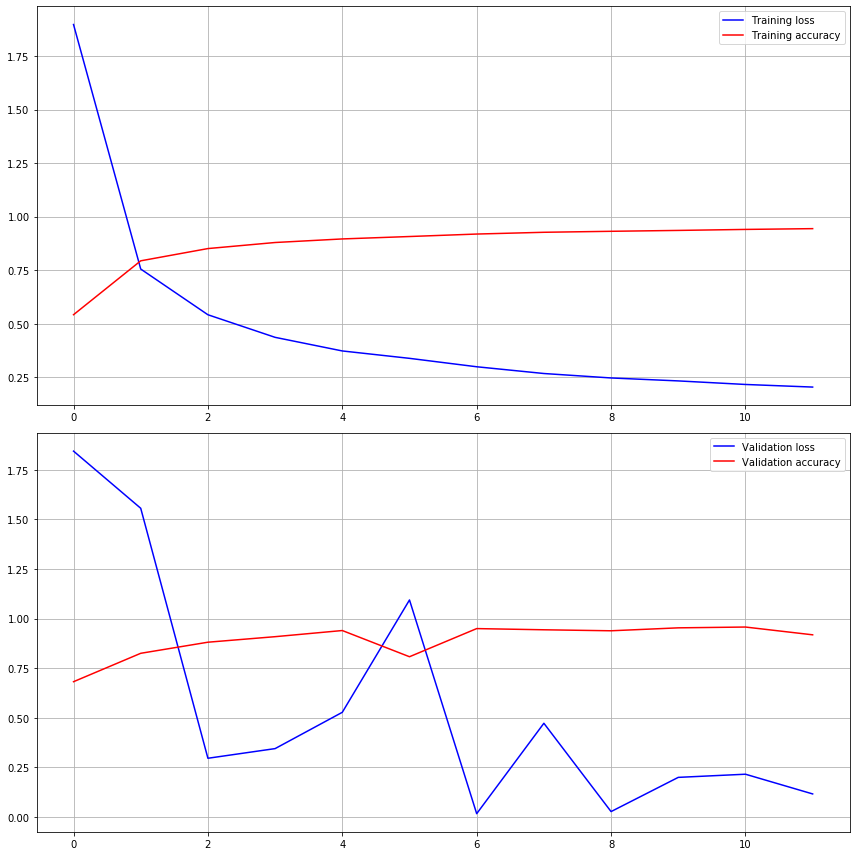

In [22]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.plot(model.history.history['loss'],color='b',label='Training loss')
ax1.plot(model.history.history['accuracy'],color='r',label='Training accuracy')
ax2.plot(model.history.history['val_loss'],color='b',label='Validation loss')
ax2.plot(model.history.history['val_accuracy'],color='r',label='Validation accuracy')
ax1.grid(True)
ax2.grid(True)
plt.tight_layout()
ax1.legend()
ax2.legend()
plt.show()

Save model

In [23]:
model.save('MedicalMask.h5')

In [24]:
model = keras.models.load_model('MedicalMask.h5')

Prediction and classification report

In [25]:
result = model.predict_generator(testing_generator)
final_result = pd.DataFrame(np.argmax(result,axis = -1),columns = ['class'])
true_class = dict((y,v) for v,y in train_generator.class_indices.items())
y_pred = np.array(final_result.replace(true_class))

In [26]:
y_true = np.array(pd.DataFrame(testing_generator.classes).replace(true_class))

In [27]:
from sklearn.metrics import confusion_matrix , classification_report
report = classification_report(y_true,y_pred)
print(report)

              precision    recall  f1-score   support

           1       0.96      1.00      0.98        92
          10       0.95      0.52      0.67       106
         100       1.00      0.91      0.95        98
         101       0.99      0.94      0.96       111
         102       0.79      0.99      0.88       118
         103       0.99      0.98      0.98        99
         104       0.99      1.00      1.00       109
         105       0.92      0.98      0.95       107
         106       0.95      0.91      0.93        87
         107       0.72      1.00      0.84       115
         108       0.98      0.87      0.92        93
         109       1.00      0.85      0.92        87
          11       0.98      0.93      0.95       111
         110       0.98      0.95      0.97       111
         111       0.97      0.99      0.98        98
         112       1.00      0.97      0.99       109
         113       0.97      0.76      0.85        94
         114       0.94    

In [28]:
import seaborn as sns
matrix = confusion_matrix(y_true[:10],y_pred[:10])

Text(69.0, 0.5, 'truth')

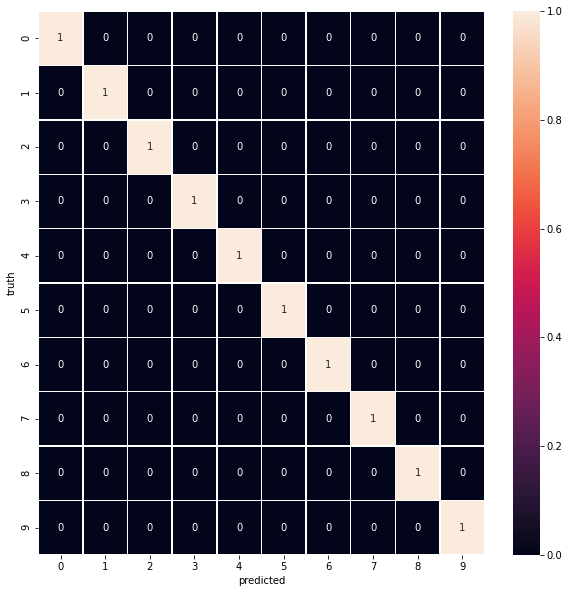

In [29]:
matrix_df = pd.DataFrame(matrix)
fig,ax = plt.subplots(figsize = (10,10))
sns.heatmap(matrix_df,annot=True, fmt = 'd',linewidth=0.5,ax=ax)
plt.xlabel('predicted')
plt.ylabel('truth')

Visualize the prediction

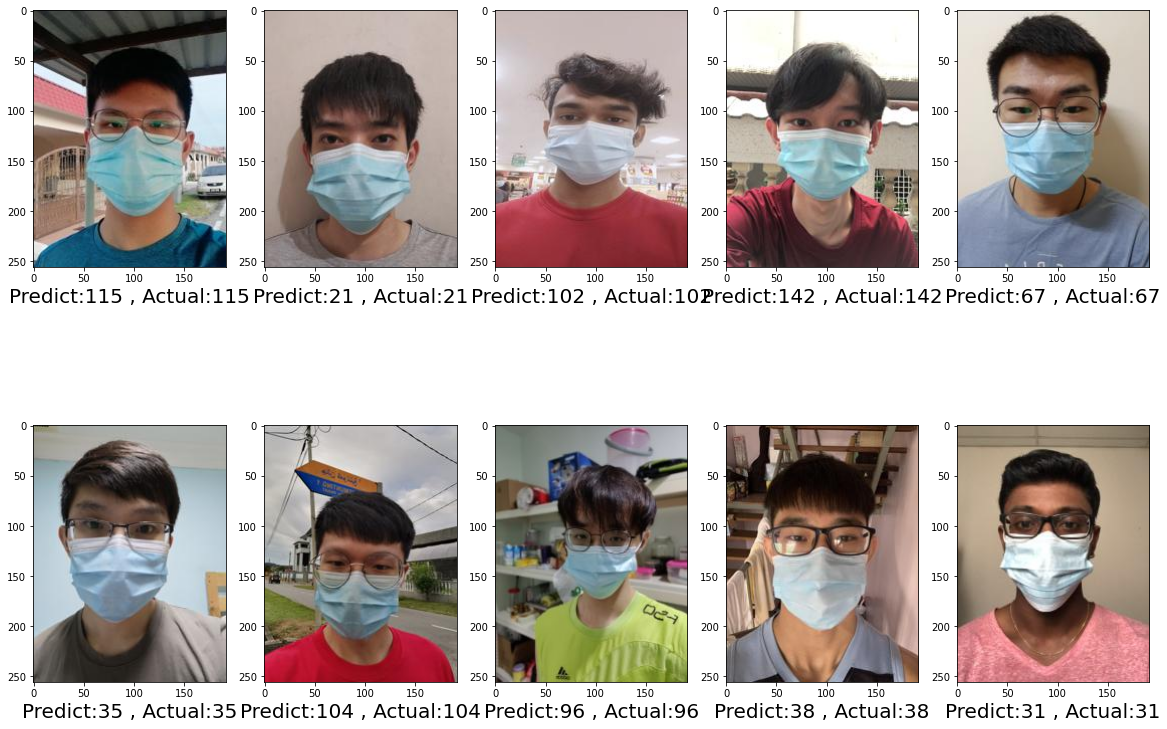

In [30]:
count = 10
images = X_test_df[:10]
plt.figure(figsize=(20,14))
for x in range(count):
    plt.subplot(2,5,x+1)
    img = cv2.imread("mask(all)/"+str(images.iloc[x][0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel("Predict:{} , Actual:{}".format(images.iloc[x][1],X_test_df.iloc[x][1]),fontsize=20)
    plt.imshow(img)